# **Import Library**

In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from skopt.space import Integer, Real, Categorical
from scipy.stats import randint, uniform

# JCOPML Package
from jcopml.plot import plot_missing_value
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import random_search_params as rsp
from jcopml.feature_importance import mean_loss_decrease
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import bayes_search_params as bsp
from jcopml.tuning import grid_search_params as gsp

In [193]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")
Id_sale = test_df["Id"]

train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,.

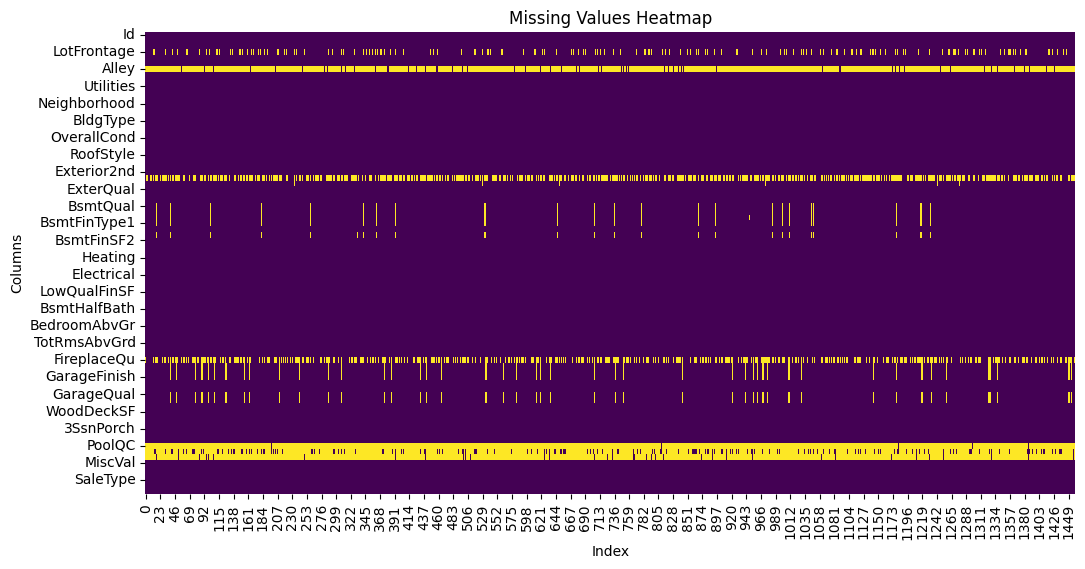

In [194]:
train_df_transposed = train_df.T

plt.figure(figsize=(12, 6))  
sns.heatmap(train_df_transposed.isnull(), cbar=False, cmap='viridis')  
plt.title("Missing Values Heatmap")
plt.xlabel("Index")
plt.ylabel("Columns")
plt.show()

In [195]:
print("\nMissing values per fitur (hanya yang di atas 0):")
missing_values = train_df.isnull().sum() 
missing_values = missing_values[missing_values > 0]  
print(missing_values)


Missing values per fitur (hanya yang di atas 0):
LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [196]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# **Delete columns that have many empty values**

In [197]:
train_df.drop(columns=["Id", "Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"], inplace=True)
test_df.drop(columns=["Id", "Alley", "MasVnrType", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"], inplace=True)

In [198]:
train_df.select_dtypes("object")

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,Plywood,Plywood,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,CemntBd,CmentBd,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,MetalSd,MetalSd,TA,TA,CBlock,TA,TA,Mn,GLQ,Rec,GasA,Gd,Y,FuseA,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


# **Fill in the columns that have missing data a little**

In [199]:
# For Train_df
for column in train_df.columns:
    most_frequent_value = train_df[column].mode()[0]  
    train_df[column] = train_df[column].fillna(most_frequent_value)

# For Test_df
for column in test_df.columns:
    most_frequent_value = test_df[column].mode()[0]  
    test_df[column] = test_df[column].fillna(most_frequent_value)

In [200]:
test_df.shape[0]

1459

In [201]:
train_df.select_dtypes(include=["object"]).columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [202]:
label_encoder = LabelEncoder()

categorical_columns = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 
                       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 
                       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 
                       'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 
                       'SaleCondition']

for column in categorical_columns:
    train_df[column] = label_encoder.fit_transform(train_df[column])
    
for column in categorical_columns:
    test_df[column] = label_encoder.fit_transform(test_df[column])

test_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2,80.0,11622,1,3,3,0,4,0,12,1,2,0,2,5,6,1961,1961,1,0,10,12,0.0,3,4,1,3,3,3,4,468.0,3,144.0,270.0,882.0,0,4,1,3,896,0,0,896,0.0,0.0,1,0,2,1,3,5,6,0,1,1961.0,2,1.0,730.0,3,4,2,140,0,0,0,120,0,0,6,2010,8,4
1,20,3,81.0,14267,1,0,3,0,0,0,12,2,2,0,2,6,6,1958,1958,3,0,11,13,108.0,3,4,1,3,3,3,0,923.0,5,0.0,406.0,1329.0,0,4,1,3,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,6,0,1,1958.0,2,1.0,312.0,3,4,2,393,36,0,0,0,0,12500,6,2010,8,4
2,60,3,74.0,13830,1,0,3,0,4,0,8,2,2,0,4,5,5,1997,1998,1,0,10,12,0.0,3,4,2,2,3,3,2,791.0,5,0.0,137.0,928.0,0,2,1,3,928,701,0,1629,0.0,0.0,2,1,3,1,3,6,6,1,1,1997.0,0,2.0,482.0,3,4,2,212,34,0,0,0,0,0,3,2010,8,4
3,60,3,78.0,9978,1,0,3,0,4,0,8,2,2,0,4,6,6,1998,1998,1,0,10,12,20.0,3,4,2,3,3,3,2,602.0,5,0.0,324.0,926.0,0,0,1,3,926,678,0,1604,0.0,0.0,2,1,3,1,2,7,6,1,1,1998.0,0,2.0,470.0,3,4,2,360,36,0,0,0,0,0,6,2010,8,4
4,120,3,43.0,5005,1,0,1,0,4,0,22,2,2,4,2,8,5,1992,1992,1,0,6,6,0.0,2,4,2,2,3,3,0,263.0,5,0.0,1017.0,1280.0,0,0,1,3,1280,0,0,1280,0.0,0.0,2,0,2,1,2,5,6,0,1,1992.0,1,2.0,506.0,3,4,2,0,82,0,0,144,0,0,1,2010,8,4


# **Remove The Outliers**

In [180]:
# Remove Outliers Train_df
Q1 = train_df.quantile(0.25)
Q3 = train_df.quantile(0.75)
IQR = Q3 - Q1

condition = ~((train_df < (Q1 - 1.5 * IQR)) | (train_df > (Q3 + 1.5 * IQR))).any(axis=1)
train_df = train_df.loc[condition, train_df.columns]

In [40]:
train_df.describe(include='all')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,145.000000,145.0,145.000000,145.000000,145.0,145.000000,145.0,145.0,145.000000,145.0,145.000000,145.0,145.0,145.0,145.000000,145.000000,145.000000,145.000000,145.000000,145.0,145.0,145.000000,145.000000,145.000000,145.000000,145.0,145.000000,145.000000,145.0,145.000000,145.000000,145.000000,145.0,145.0,145.000000,145.000000,145.0,145.000000,145.0,145.0,145.000000,145.000000,145.0,145.000000,145.000000,145.0,145.000000,145.000000,145.000000,145.0,145.000000,145.000000,145.0,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.0,145.0,145.0,145.000000,145.000000,145.0,145.0,145.0,145.0,145.0,145.000000,145.000000,145.0,145.0,145.000000
mean,44.034483,3.0,68.372414,9774.241379,1.0,1.427586,3.0,0.0,2.951724,0.0,10.696552,2.0,2.0,0.0,3.737931,6.296552,5.310345,1990.558621,1994.075862,1.0,1.0,10.172414,11.089655,71.917241,2.489655,4.0,1.724138,2.262069,3.0,2.848276,2.868966,401.358621,5.0,0.0,590.910345,992.268966,1.0,0.917241,1.0,4.0,1049.551724,488.758621,0.0,1538.310345,0.400000,0.0,1.751724,0.620690,3.055172,1.0,2.358621,6.703448,6.0,0.572414,1.524138,1992.372414,0.889655,1.834483,468.158621,4.0,4.0,2.0,93.020690,41.420690,0.0,0.0,0.0,0.0,0.0,6.124138,2007.931034,8.0,4.0,184835.048276
std,20.827470,0.0,11.930903,2106.285235,0.0,1.480169,0.0,0.0,1.638644,0.0,5.685415,0.0,0.0,0.0,1.691567,1.067995,0.606873,16.664531,13.979192,0.0,0.0,2.711459,2.957846,100.785561,0.501626,0.0,0.463722,0.441284,0.0,0.446141,1.768769,365.613652,0.0,0.0,374.250973,266.351174,0.0,1.431314,0.0,0.0,259.924453,449.945402,0.0,398.470278,0.491596,0.0,0.449244,0.486897,0.510709,0.0,0.481258,1.179243,0.0,0.586241,1.130897,15.121703,0.737085,0.577516,163.408557,0.0,0.0,0.0,104.099676,36.030787,0.0,0.0,0.0,0.0,0.0,2.491326,1.326311,0.0,0.0,42666.262434
min,20.000000,3.0,37.000000,5500.000000,1.0,0.000000,3.0,0.0,0.000000,0.0,5.000000,2.0,2.0,0.0,0.000000,4.000000,4.000000,1940.000000,1950.000000,1.0,1.0,3.000000,5.000000,0.000000,2.000000,4.0,0.000000,2.000000,3.0,1.000000,0.000000,0.000000,5.0,0.0,40.000000,384.000000,1.0,0.000000,1.0,4.0,663.000000,0.000000,0.0,816.000000,0.000000,0.0,1.000000,0.000000,1.000000,1.0,2.000000,4.000000,6.0,0.000000,1.000000,1940.000000,0.000000,0.000000,0.000000,4.0,4.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,2006.000000,8.0,4.0,82500.000000
25%,20.000000,3.0,60.000000,8197.000000,1.0,0.000000,3.0,0.0,1.000000,0.0,5.000000,2.0,2.0,0.0,2.000000,6.000000,5.000000,1982.000000,1992.000000,1.0,1.0,8.000000,8.000000,0.000000,2.000000,4.0,1.000000,2.000000,3.0,3.000000,2.000000,0.000000,5.0,0.0,284.000000,833.000000,1.0,0.000000,1.0,4.0,858.000000,0.000000,0.0,1214.000000,0.000000,0.0,1.000000,0.000000,3.000000,1.0,2.000000,6.000000,6.0,0.000000,1.000000,1986.000000,0.000000,2.000000,400.000000,4.0,4.0,2.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,5.000000,2007.000000,8.0,4.0,158000.000000
50%,60.000000,3.0,65.000000,9382.000000,1.0,0.000000,3.0,0.0,4.000000,0.0,8.000000,2.0,2.0,0.0,5.000000,7.000000,5.000000,1998.000000,2000.000000,1.0,1.0,12.000000,13.000000,0.000000,2.000000,4.0,2.000000,2.000000,3.0,3.000000,2.000000,445.000000,5.0,0.0,524.000000,952.000000,1.0,0.000000,1.0,4.0,990.000000,678.000000,0.0,1571.000000,0.0

# **Visualization The Data**

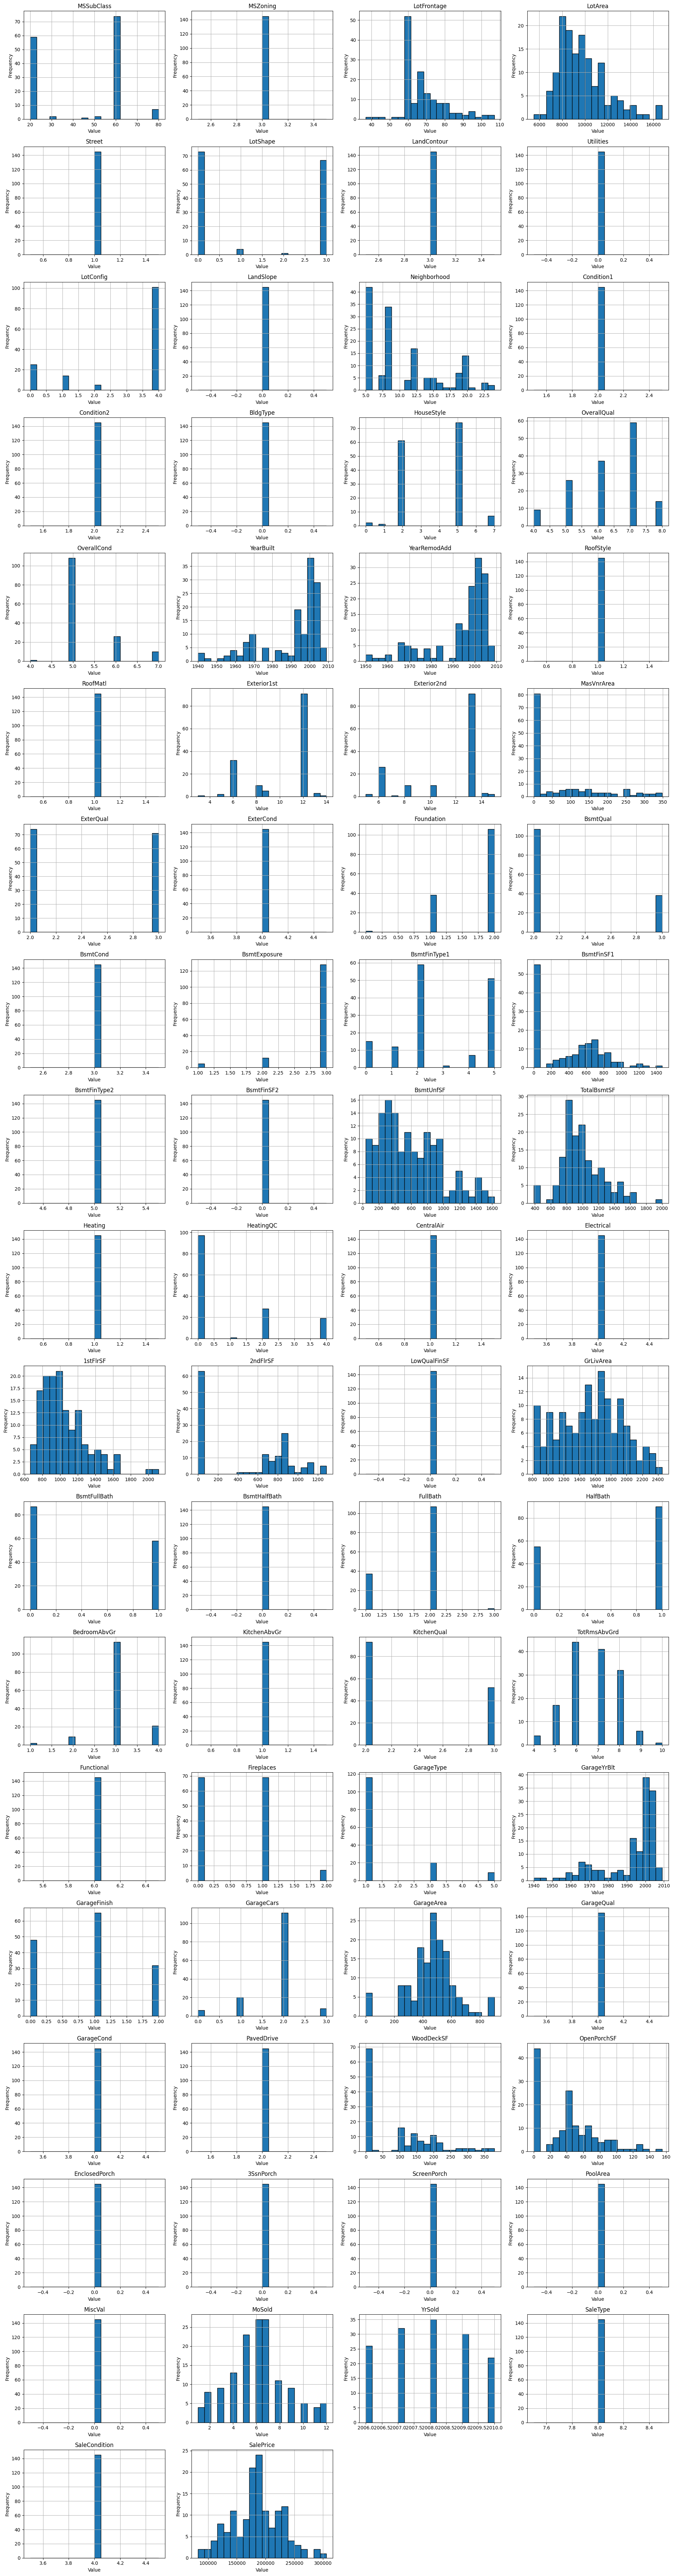

In [41]:
num_vars = train_df.shape[1]
n_cols = 4 
n_rows = -(-num_vars // n_cols) 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))

axes = axes.flatten()
 
for i, column in enumerate(train_df.columns):
    train_df[column].hist(ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
 
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
 
plt.tight_layout()
plt.show()

# **Pick The Feature**

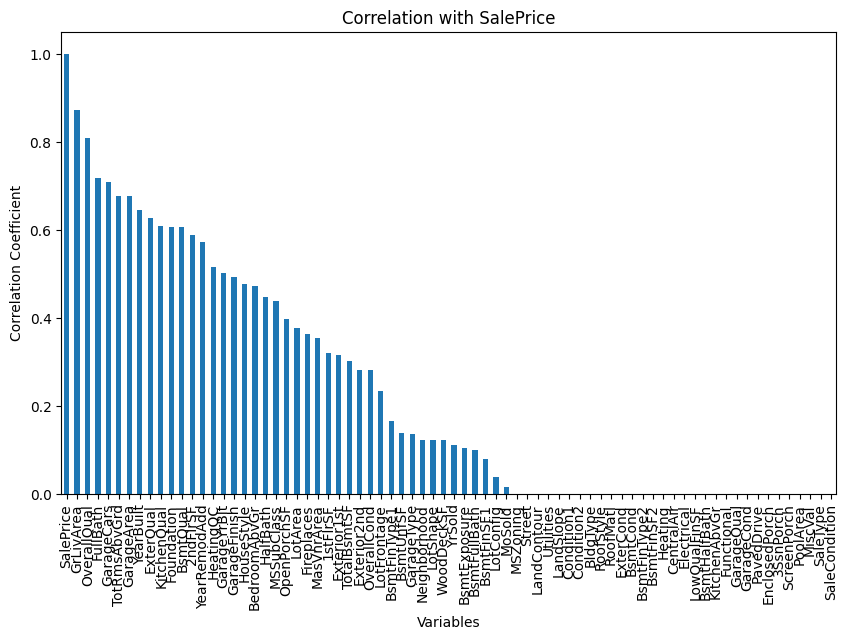

In [43]:
target_corr = train_df.corr()['SalePrice']

target_corr_sorted = target_corr.abs().sort_values(ascending=False)
 
plt.figure(figsize=(10, 6))
target_corr_sorted.plot(kind='bar')
plt.title(f'Correlation with SalePrice')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.show()

In [132]:
correlated_features = target_corr[target_corr.abs() > 0.0].index

print("Fitur yang berkorelasi tinggi dengan SalePrice:")
print(len(correlated_features))

Fitur yang berkorelasi tinggi dengan SalePrice:
43


In [151]:
len(train_df.columns)

74

# **Train with All train_df columns**

In [203]:
X = train_df.drop(columns=['SalePrice'])
y = train_df['SalePrice']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1168, 73), (292, 73), (1168,), (292,))

In [204]:
preprocessor = ColumnTransformer([ 
    ('numeric', num_pipe(scaling="robust"), X_train.columns)
])

## **RandomForest with RandomizedSearchCV**

### **Train With Parameters JCOPML**

In [71]:
rsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200),
 'algo__max_depth': Integer(low=20, high=80),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform'),
 'algo__min_samples_leaf': Integer(low=1, high=20)}

In [205]:
pipeline = Pipeline([ 
    ("prep", preprocessor),
    ("algo", RandomForestRegressor())  
])

model_regresi_RF_random = RandomizedSearchCV(pipeline, rsp.rf_params, n_iter=50, cv=5, n_jobs=-1, verbose=1)
model_regresi_RF_random.fit(X_train, y_train)

print(model_regresi_RF_random.best_params_)
print(model_regresi_RF_random.score(X_train, y_train), model_regresi_RF_random.best_score_, model_regresi_RF_random.score(X_val, y_val))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'algo__max_depth': 72, 'algo__max_features': 0.45030384049843286, 'algo__min_samples_leaf': 4, 'algo__n_estimators': 186}
0.9384283954537713 0.8516208034457626 0.8721120322292891


In [206]:
best_model_RF_random = model_regresi_RF_random.best_estimator_
y_pred_RF_random = best_model_RF_random.predict(X_val)

mae_RF_random    = mean_absolute_error(y_val,y_pred_RF_random)
mse_RF_random    = mean_squared_error(y_val,y_pred_RF_random)
r2_RF_random     = r2_score(y_val,y_pred_RF_random)
rmse_RF_random   = np.sqrt(mse_RF_random)
 
print(f"MAE     : {mae_RF_random}")
print(f"MSE     : {mse_RF_random}")
print(f"R²      : {r2_RF_random}")
print(f"RMSE    : {rmse_RF_random}")

MAE     : 16617.35693962024
MSE     : 912089744.6795512
R²      : 0.8721120322292891
RMSE    : 30200.823576180024


In [208]:
test_df_RSV = best_model_RF_random.predict(test_df)

In [209]:
submission_df_xgb_reg = pd.DataFrame({
    'Id': Id_sale,  
    'SalePrice': test_df_RSV
})
submission_df_xgb_reg.to_csv('submissionRFRegresi.csv', index=False)

### **Train Without Parameters JCOPML**

In [84]:
param_RF_rsp = {
    'algo__n_estimators': [50, 75, 100],       
    'algo__max_depth': [5, 10, 15],           
    'algo__max_features': [0.3, 0.5, 0.7],     
    'algo__min_samples_leaf': [5, 10, 15],      
    'algo__min_samples_split': [5, 10, 20],     
}

In [85]:
preprocessor = ColumnTransformer([ 
    ('numeric', num_pipe(scaling="minmax"), X_train.columns)
])

pipeline = Pipeline([ 
    ("prep", preprocessor),
    ("algo", RandomForestRegressor())  
])

model_regresi_RF_random_param = RandomizedSearchCV(pipeline, param_RF_rsp, n_iter=50, cv=5, n_jobs=-1, verbose=1)
model_regresi_RF_random_param .fit(X_train, y_train)

print(model_regresi_RF_random_param.best_params_)
print(model_regresi_RF_random_param .score(X_train, y_train), model_regresi_RF_random_param .best_score_, model_regresi_RF_random_param .score(X_val, y_val))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'algo__n_estimators': 100, 'algo__min_samples_split': 10, 'algo__min_samples_leaf': 5, 'algo__max_features': 0.7, 'algo__max_depth': 15}
0.935968362001088 0.839033541555227 0.8528483186899946


In [91]:
best_model_RF_random_param = model_regresi_RF_random_param.best_estimator_
y_pred_RF_random_param = best_model_RF_random_param.predict(X_val)

mae_RF_random_param    = mean_absolute_error(y_val,y_pred_RF_random_param)
mse_RF_random_param    = mean_squared_error(y_val,y_pred_RF_random_param)
r2_RF_random_param     = r2_score(y_val,y_pred_RF_random_param)
rmse_RF_random_param   = np.sqrt(mse_RF_random_param)
 
print(f"MAE     : {mae_RF_random_param}")
print(f"MSE     : {mse_RF_random_param}")
print(f"R²      : {r2_RF_random_param}")
print(f"RMSE    : {rmse_RF_random_param}")

MAE     : 13691.329841237306
MSE     : 376851228.5048164
R²      : 0.8528483186899946
RMSE    : 19412.656400009157


## **RandomForest with BayesSearchCV**

In [88]:
bsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200, prior='uniform', transform='identity'),
 'algo__max_depth': Integer(low=20, high=80, prior='uniform', transform='identity'),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform', transform='identity'),
 'algo__min_samples_leaf': Integer(low=1, high=20, prior='uniform', transform='identity')}

In [89]:
pipeline = Pipeline([ 
    ("prep", preprocessor),
    ("algo", RandomForestRegressor())  
])

model_regresi_RF_bayes = BayesSearchCV(pipeline, bsp.rf_params, n_iter=50, cv=5, n_jobs=-1, verbose=1)
model_regresi_RF_bayes.fit(X_train, y_train)

print(model_regresi_RF_bayes.best_params_)
print(model_regresi_RF_bayes.score(X_train, y_train), model_regresi_RF_bayes.best_score_, model_regresi_RF_bayes.score(X_val, y_val))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [115]:
best_model_RF_bayes = model_regresi_RF_bayes.best_estimator_
y_pred_RF_bayes = best_model_RF_bayes.predict(X_val)

mae_RF_bayes    = mean_absolute_error(y_val,y_pred_RF_bayes)
mse_RF_bayes    = mean_squared_error(y_val,y_pred_RF_bayes)
r2_RF_bayes     = r2_score(y_val,y_pred_RF_bayes)
rmse_RF_bayes   = np.sqrt(mse_RF_bayes)
 
print(f"MAE     : {mae_RF_bayes}")
print(f"MSE     : {mse_RF_bayes}")
print(f"R²      : {r2_RF_bayes}")
print(f"RMSE    : {rmse_RF_bayes}")

MAE     : 12853.088965517243
MSE     : 376170479.1595724
R²      : 0.853114135551202
RMSE    : 19395.114827181933


In [94]:
bsp.rf_params

{'algo__n_estimators': Integer(low=100, high=200, prior='uniform', transform='normalize'),
 'algo__max_depth': Integer(low=20, high=80, prior='uniform', transform='normalize'),
 'algo__max_features': Real(low=0.1, high=1, prior='uniform', transform='normalize'),
 'algo__min_samples_leaf': Integer(low=1, high=20, prior='uniform', transform='normalize')}

In [188]:
rf_bayes_params = {
    'algo__n_estimators': Integer(low=75, high=100, prior='uniform', transform='normalize'),
    'algo__max_depth': Integer(low=10, high=40, prior='uniform', transform='normalize'),
    'algo__max_features': Real(low=0.1, high=1, prior='uniform', transform='normalize'),
    'algo__min_samples_leaf': Integer(low=1, high=20, prior='uniform', transform='normalize')
}

In [210]:
pipeline = Pipeline([ 
    ("prep", preprocessor),
    ("algo", RandomForestRegressor())  
])

model_regresi_RF_bayes_param = BayesSearchCV(pipeline, rf_bayes_params, n_iter=50, cv=5, n_jobs=-1, verbose=1)
model_regresi_RF_bayes_param .fit(X_train, y_train)

print(model_regresi_RF_bayes_param .best_params_)
print(model_regresi_RF_bayes_param .score(X_train, y_train), model_regresi_RF_bayes_param .best_score_, model_regresi_RF_bayes_param .score(X_val, y_val))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [211]:
best_model_RF_bayes_param = model_regresi_RF_bayes_param.best_estimator_
y_pred_RF_bayes_param = best_model_RF_bayes_param.predict(X_val)

mae_RF_bayes_param    = mean_absolute_error(y_val,y_pred_RF_bayes_param)
mse_RF_bayes_param    = mean_squared_error(y_val,y_pred_RF_bayes_param)
r2_RF_bayes_param     = r2_score(y_val,y_pred_RF_bayes_param)
rmse_RF_bayes_param   = np.sqrt(mse_RF_bayes_param)
 
print(f"MAE     : {mae_RF_bayes_param}")
print(f"MSE     : {mse_RF_bayes_param}")
print(f"R²      : {r2_RF_bayes_param}")
print(f"RMSE    : {rmse_RF_bayes_param}")

MAE     : 16196.374684571017
MSE     : 782661680.5813527
R²      : 0.8902596895037729
RMSE    : 27976.09123128806


In [150]:
print(len(train_df.columns)) 
print(len(test_df.columns))

74
73


In [163]:
test_df.shape[0]

160

In [213]:
test_df_RF_BSP = best_model_RF_bayes_param.predict(test_df)

In [214]:
submission_df_xgb_reg = pd.DataFrame({
    'Id': Id_sale,  
    'SalePrice': test_df_RF_BSP 
})
submission_df_xgb_reg.to_csv('submissionRF_reg.csv', index=False)